In [171]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
from scipy.integrate import odeint
from scipy import interpolate
from scipy.optimize import minimize
import warnings

In [172]:
def integ(x, tck, constant=0):
    '''
    Spline integration function. Curvature and deflection at butt are asuumed to be 0.
    '''
    x = np.atleast_1d(x)
    out = np.zeros(x.shape, dtype=x.dtype)
    for n in range(len(out)):
        out[n] = interpolate.splint(0, x[n], tck)
    out += constant
    return out


def get_deflection(length, num_markers, EI, fp, r_p):
    '''
    get_deflection takes club data - club length, number of markers, EI profile, r_p - and the input force.
    The function returns the y and z deflections and displays plots of M/EI, curvature and deflection. 
    
    Note: EI is a 6th order polynomial. r_p, L_p and fp all wrt to standard xyz
    '''
    xs = np.linspace(0,length,num_markers)
    mz_eiofx = []
    my_eiofx = []
    L_p = [1,0,0]
    moment_grip = np.cross(L_p,fp)
    moment_head = np.cross(r_p,fp)
    
    
    fig = plt.figure(figsize=(15,10))
    gs  = gridspec.GridSpec(3, 1, height_ratios=[1, 1 , 1],hspace = 1)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    ax0.locator_params(axis = 'y', nbins=10)
    ax1.locator_params(axis = 'y', nbins=10)
    ax2.locator_params(axis = 'y', nbins=10)
    ax0.set_xlabel('x from butt')

    
    ####calculating and plotting m_z/EI(x)
    moment_z_points = []
    for x in xs:
        result = ((length-x)*moment_grip[2])/length+(x/length)*moment_head[2]
        #print("m_z", result)
        moment_z_points.append(result)
        stiffness = np.polyval(EI, x)
        mz_eiofx.append(result/stiffness)
    d2y_pts = np.array(mz_eiofx)
    
    d2y_spl_data = interpolate.splrep(xs, d2y_pts, s=0)
    d2y_spline = interpolate.splev(xs, d2y_spl_data, der=0)
    ax0.plot(xs,d2y_spline,  label = 'M_z/EI')
    ax0.set_title('M/EI')

    ####calculating and plotting m_y/EI(x)
    moment_y_points = []
    for x in xs:
        result = ((length-x)*moment_grip[1])/length+(x/length)*moment_head[1]
        moment_y_points.append(result)
        stiffness = np.polyval(EI, x)
        my_eiofx.append(result/stiffness)
    d2z_pts = np.array(my_eiofx)
    
    d2z_spl_data = interpolate.splrep(xs, d2z_pts, s=0)
    d2z_spline = interpolate.splev(xs, d2z_spl_data, der=0)
    ax0.plot(xs,d2z_spline,  label = 'M_y/EI')
    ax0.legend()
    
    
    ####integrating twice to determine y-axis deflection
    dy_spline = integ(xs, d2y_spl_data)
    ax1.plot(xs,dy_spline, label = 'y')
    ax1.set_title('Curvature')
    ax1.set_xlabel('x from butt')
    dy_spl_data = interpolate.splrep(xs, dy_spline, s=0)
    y_spline = integ(xs,dy_spl_data)
    ax2.plot(xs,y_spline,  label = 'y')
    ax2.set_title('Deflection')
    ax2.set_xlabel('x from butt')
    
    ####integrating twice to determine z-axis deflection
    dz_spline = integ(xs, d2z_spl_data)
    #print(yint)
    #print(xs)
    ax1.plot(xs,dz_spline,  label = 'z')
    ax1.legend()
    dz_spl_data = interpolate.splrep(xs, dz_spline, s=0)
    z_spline = integ(xs,dz_spl_data)
    ax2.plot(xs,z_spline, label = 'z')
    ax2.legend()
    
    ####returning deflections
    deflections = (list(y_spline),list(z_spline))
    return deflections

In [173]:
def position_to_deflection(position,y_axis_point):
    """
    position_to_deflection orients mo-cap points in R3 into y and z deflections in the standard xyz coordinate system.
    """
    y_deflection = []
    z_deflection = []
    x_unit = []
    y_unit = []
    for i in range(0,3):
        x_unit.append(position[1][i]-position[0][i])
        y_unit.append(y_axis_point[i]-position[0][i])
    z_unit = np.cross(x_unit,y_unit)
    for i in range(len(position)):
        a = np.array([[x_unit[0],y_unit[0],z_unit[0]], [x_unit[1],y_unit[1],z_unit[1]],[x_unit[2],y_unit[2],z_unit[2]]])
        #a = np.array([[1,0,0], [0,1,0],[0,0,1]])
        axis_point = [element * i for element in x_unit]
        b = np.array([position[i][0]-axis_point[0],position[i][1]-axis_point[1],position[i][2]-axis_point[2]])
        x = np.linalg.solve(a, b)
        y_deflection.append(x[1])
        z_deflection.append(x[2])
    deflections = (y_deflection,z_deflection)
    return deflections


In [177]:
def generate_force_profile(length, num_markers, EI, deflections,r_p):
    '''
    generate_force_profile takes club information - club length, number of markers, EI profile, r_p - and
    deflection data captured by mo-cap. The function returns the input y and z force determined through optimization
    and the error in the optimization.
    
    Note: EI is a 6th order polynomial. r_p, L_p and fp all wrt to standard xyz
    '''
    y_spline = deflections[0]
    z_spline = deflections[1]
    xs = np.linspace(0,length,num_markers)
    
    ####take two derivatives of y deflection
    y_spl2_data = interpolate.splrep(xs, y_spline, s=0)
    y_spline2 = interpolate.splev(xs, y_spl2_data, der=0)
    dy_spline2 = interpolate.splev(xs, y_spl2_data, der=1)
    d2y_spline2 = interpolate.splev(xs, y_spl2_data, der=2)
    plt.plot(xs,d2y_spline2, label = "M_z/EI")
    plt.title("Recovered M/EI")
    plt.xlabel("x from butt")



    ####take two derivatives of z deflection
    z_spl2_data = interpolate.splrep(xs, z_spline, s=0)
    d2z_spline2 = interpolate.splev(xs, z_spl2_data, der=2)
    plt.plot(xs,d2z_spline2, label = "M_y/EI")
    plt.legend()
    
    
    ####Determine moment about z-axis
    M_z = []
    for i in range(len(xs)):
        stiffness = np.polyval(EI, xs[i])
        M_z.append(d2y_spline2[i]*stiffness)
    

    ####Determine moment about y-axis
    M_y = []
    for i in range(len(xs)):
        stiffness = np.polyval(EI, xs[i])
        M_y.append(d2z_spline2[i]*stiffness)
    
    ####guess Fp
    
    def spline_guess_error(fp):
        fp_y = fp[0]
        fp_z = fp[1]
        full_fp = [0,fp[0],fp[1]]
        L_p = [1,0,0]

        moment_grip = np.cross(L_p,full_fp)
        moment_head = np.cross(r_p,full_fp)
        y_error = 0
        z_error = 0
        for i in range(len(xs)):
            result_y = ((length-xs[i])*moment_grip[1])/length+(xs[i]/length)*moment_head[1]
            result_z = ((length-xs[i])*moment_grip[2])/length+(xs[i]/length)*moment_head[2]
            y_error += abs(result_y - M_y[i])
            z_error += abs(result_z - M_z[i])
        tot_error = y_error+z_error
        return tot_error
    
    
    
    initial_guess = [5,0]
    fp = minimize(spline_guess_error,initial_guess, method = 'COBYLA')
    return (list(fp.x),fp.fun)


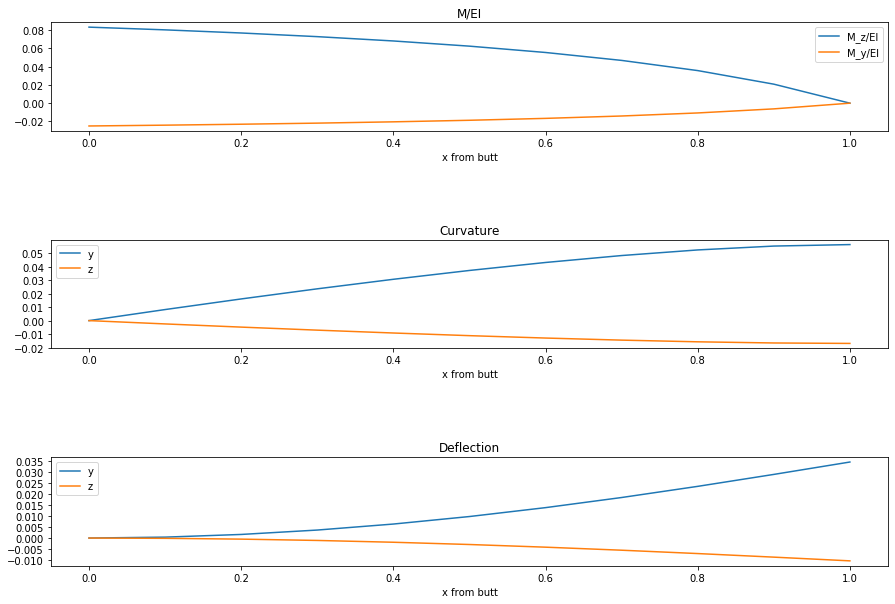

In [182]:
shaft1 = get_deflection(1,11,[0,0,0,0,-80,120],[0,10,3],[0,0,0])

([10.01199235814604, 3.0035931772022577], 0.37489337325548777)

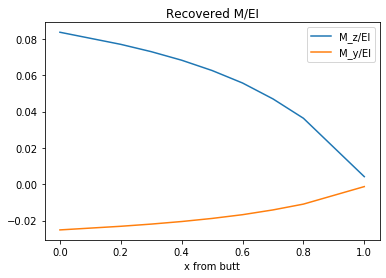

In [183]:
generate_force_profile(1,11, [0,0,0,0,0,-80,120],shaft1,[0,0,0])